In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [36]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D
from population import unit_response_matrix, activity_at_phase
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json

In [37]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [43]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]
try:
    selected.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
try:
    selected.remove('009265_hippoSIT_2023-02-27_10-18-32')
    selected.remove('009265_hippoSIT_2023-02-27_15-33-46')
except:
    pass

# 009266
idxs_f = np.array([0, 1, 2, 3, 7, 8, 10, 13, 14, 15], dtype=np.int32)
idxs_d = np.array([4, 9, 11, 12], dtype=np.int32)
idxs_a = np.array([5, 6, 16])
idxs_l = []

def which_type(idx):
    if idx in idxs_f:
        return 'Frequency'
    elif idx in idxs_d:
        return 'Duration'
    elif idx in idxs_a:
        return 'Amplitude'
    elif idx in idxs_l:
        return 'Location'
    else:
        return 'Unknown'

# special for 009265
#selected = selected[7:-1]

# showcase
# selected = [
#     '009266_hippoSIT_2023-05-04_19-47-15',
#     '009266_hippoSIT_2023-04-17_17-04-17',
#     '009266_hippoSIT_2023-05-23_09-18-05'
# ]

selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

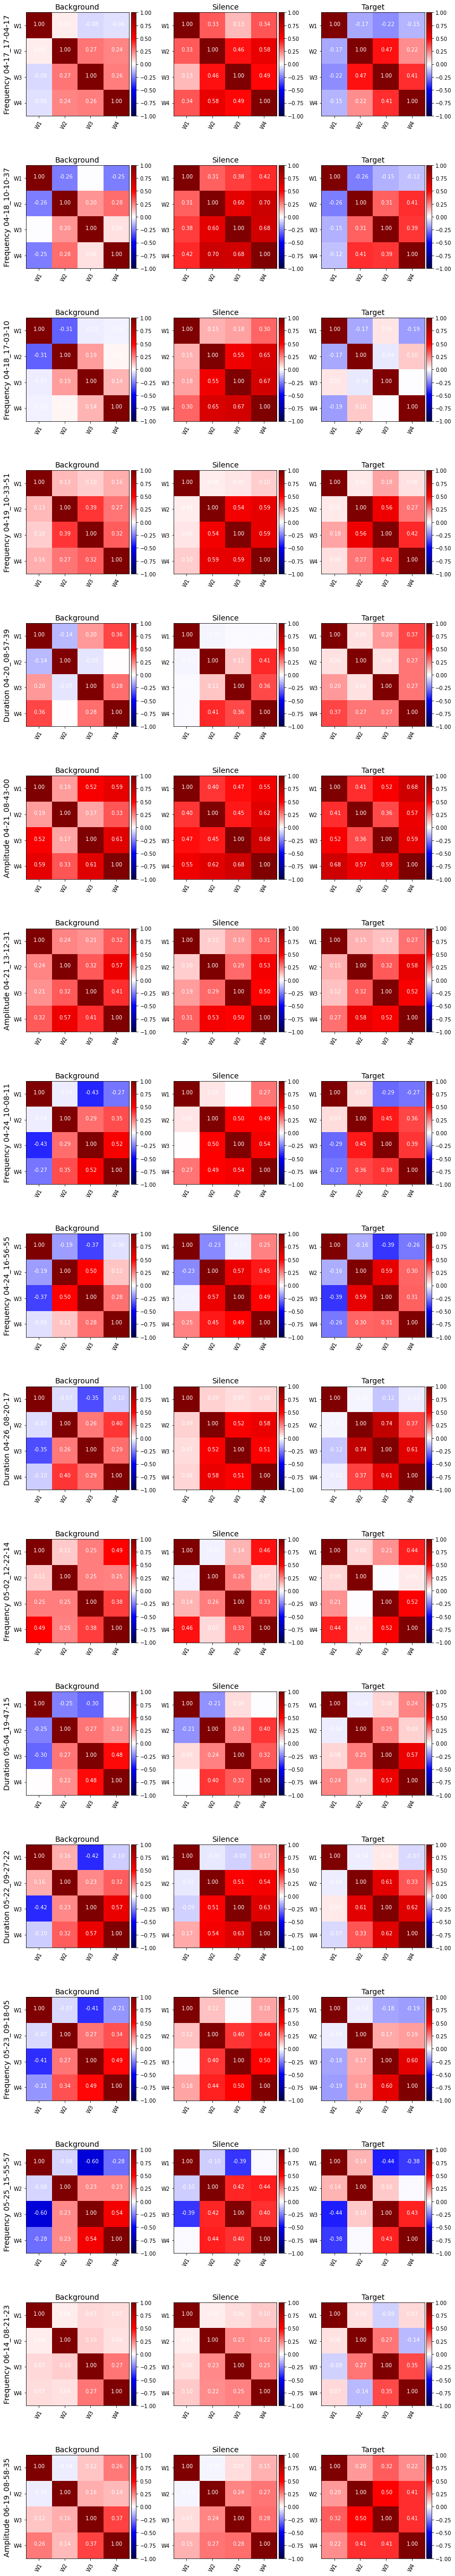

In [44]:
#rows = int(len(selected)/3) + 1
rows = len(selected)
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
titles = ['Background', 'Silence', 'Target']

for k, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path = os.path.join(source, animal, session)
    meta_file = os.path.join(source, animal, session, 'meta.h5')
    with h5py.File(meta_file, 'r') as f:
        #tl = np.array(f['processed']['timeline'])
        cfg = json.loads(f['processed'].attrs['parameters'])
        events = np.array(f['processed']['sound_events'])

    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]

    wx = [
        activity_at_phase(s_path, phase=1, do_pca=True, k_width=30),
        activity_at_phase(s_path, phase=2, do_pca=True, k_width=30),
        activity_at_phase(s_path, phase=3, do_pca=True, k_width=30),
        activity_at_phase(s_path, phase=4, do_pca=True, k_width=30)
    ]

    for l, idxs in enumerate([idxs_bgr_ev, idxs_sil_ev, idxs_tgt_ev]):
        corr_pearson = np.zeros((4, 4))
        for i in range(len(wx)):
            for j in range(len(wx)):
                corr_pearson[i, j] = stats.pearsonr(wx[i][idxs], wx[j][idxs])[0]

        metric_names = ['W1', 'W2', 'W3', 'W4']
        ax = axes[k][l]
        im = ax.imshow(corr_pearson, cmap='seismic', vmin=-1)
        ax.set_xticks(range(corr_pearson.shape[1]))
        ax.set_xticklabels(metric_names, rotation=60)
        ax.set_yticks(range(corr_pearson.shape[0]))
        _ = ax.set_yticklabels(metric_names)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax.set_title(titles[l], fontsize=14)
        if l == 0:
            ax.set_ylabel('%s %s' % (which_type(k), session[-14:]), fontsize=14)
        for p in range(corr_pearson.shape[0]):
            for q in range(corr_pearson.shape[1]):
                ax.text(p - 0.2, q, '%.2f' % corr_pearson[p, q], color='white')
            
fig.tight_layout()